Tim Day
862016623
CS105

In [1]:
## Config ## Start #

# Update live/historic data
updateLive = True
updateHistoric = True

# Historic Dates
start_date = '2020-02-10'
end_date = '2020-02-21'

# print verbose scraper output
print_scraper_output = False

## Config ## End #

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplt
%matplotlib inline
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import parallel_coordinates
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## Get Historic Data Func ## START #

def get_historic_to_csv(stocks_list, start, end, col, verbose=0):

    # get stock names from txt file
    #f = open('./data_files/stock_name.txt', 'r')
    #stocks_list = f.read().splitlines()
    #f.close()

    # create dataframe
    dataOpen = pd.DataFrame(columns=stocks_list)
    dataClose = pd.DataFrame(columns=stocks_list)
    dataVolume = pd.DataFrame(columns=stocks_list)
    
    # Fetch price open data
    for ticker in stocks_list:
        dataOpen[ticker] = yf.download(ticker, start, end)[col[0]]
        if not verbose:
            clear_output()

    # Fetch price close data
    for ticker in stocks_list:
        dataClose[ticker] = yf.download(ticker, start, end)[col[1]]
        if not verbose:
            clear_output()
            
    # Fetch volume data
    for ticker in stocks_list:
        dataVolume[ticker] = yf.download(ticker, start, end)[col[2]]
        if not verbose:
            clear_output()

    # Transpose 
    dataOpen = dataOpen.T
    dataClose = dataClose.T
    dataVolume = dataVolume.T
    
    # save a csv version of stock data
    dataOpen.to_csv('./data_files/yfinance_nasdaq_100_hist_open.csv')
    dataClose.to_csv('./data_files/yfinance_nasdaq_100_hist_close.csv')
    dataVolume.to_csv('./data_files/yfinance_nasdaq_100_hist_volume.csv')

    # clear scrape messages
    #clear_output()

## Get Historic Data Func ## END #

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

## Get Live Data Func ## START #

def get_live_to_csv():
    # get url
    nasdaq_top_100 = requests.get('https://www.stockmonitor.com/nasdaq-stocks/')

    # parse with BS4
    soup = BeautifulSoup(nasdaq_top_100.content,"html.parser")

    # pull data for columns
    tmp_lst=[]
    for row in soup.table.find_all('tr')[1:]:
        r_td = row.find_all('td')
        f=[]
        for obj in r_td:
            temp = obj.text.replace("\n","")
            f.append(temp.replace(" ",""))
        tmp_lst.append(f)
    
    # create dataframe
    df = pd.DataFrame(data = tmp_lst, columns = ["change","symbol","name","price","volume","high","low"])
    
    # clean data
    df['high'] = df['high'].str.replace(',','')
    df['high'] = df['high'].str.replace('\r','')
    df['low'] = df['low'].str.replace(',','')
    df['low'] = df['low'].str.replace('\r','')
    df['price'] = df['price'].str.replace(',','')
    df['price'] = df['price'].str.replace('\r','')
    df['volume'] = df['volume'].str.replace('\r', '')
    df['volume'] = df['volume'].str.replace(',', '')
    df['name'] = df['name'].str.replace('\r', '')
    df['change'] = df['change'].str[1:-1].astype(float)

    # specify types
    df['high'] = df['high'].astype('float')
    df['low'] = df['low'].astype('float')
    df['price'] = df['price'].astype('float')
    df['volume'] = df['volume'].astype('int')
    
    # list of current top 100 stocks
    top_100 = []
    top_100 = list(df['symbol'])

    # set symbol as index
    df.set_index('symbol',inplace=True)

    # save to csv
    df.to_csv('./data_files/nasdaq_top_100.csv')
    
    # save stock list to file
    with open('./data_files/stock_list_current.txt', 'w+') as f:
        for listitem in top_100:
            f.write('%s\n' % listitem)
    
    return top_100

## Get Live Data Func ## END #

In [4]:
## Main Function Calls ## START #

stock_list = []
# live top 100 nasdaq -> nasdaq_top_100.csv
if updateLive == True:
  stock_list = get_live_to_csv()

# get stock list if get live stocks not previuosly run
if stock_list == []:
    with open('./data_files/stock_list_current.txt', 'r') as f:
        for line in f:
            currentPlace = line[:-1]
            stock_list.append(currentPlace)

# historic dates -> yfinance_nasdaq_100.csv
col_data = ['Open','Adj Close','Volume']
if updateHistoric == True:
  get_historic_to_csv(stock_list, start_date, end_date, col_data, print_scraper_output)

## Function Calls ## END #

In [5]:
## Data Combine ## Start #

# historic data
df_Open = pd.read_csv('./data_files/yfinance_nasdaq_100_hist_open.csv', index_col=0).astype(float)
df_Close = pd.read_csv('./data_files/yfinance_nasdaq_100_hist_close.csv', index_col=0).astype(float)
df_Volume = pd.read_csv('./data_files/yfinance_nasdaq_100_hist_volume.csv', index_col=0).astype(int)

# live data
df_live = pd.read_csv('./data_files/nasdaq_top_100.csv', index_col=0)

# calculate percent change
df_diff = df_Open.subtract(df_Close)
df_pChange = df_diff.divide(df_Open)

# find cuurent top five positive movers of the day from live data
df_top5_live = (df_live.sort_values(by=['change']))[-5:]
top5_list = list(df_top5_live.index)

### ML training set
## Features: TODO Phase 3

## Data Combine ## End #

In [6]:
## Normalize ## Start #

# normalize
df_Vol_normed=(df_Volume.T-df_Volume.T.mean())/df_Volume.T.std()
df_Open_normed=(df_Open.T-df_Open.T.mean())/df_Open.T.std()
df_Close_normed=(df_Close.T-df_Close.T.mean())/df_Close.T.std()
df_diff_normed=(df_diff.T-df_diff.T.mean())/df_diff.T.std()
df_pChange_normed=(df_pChange.T-df_pChange.T.mean())/df_pChange.T.std()

# formatting
df_Vol_normed = df_Vol_normed.T
df_Open_normed = df_Open_normed.T
df_Close_normed = df_Close_normed.T
df_diff_normed = df_diff_normed.T
df_pChange_normed = df_pChange_normed.T

## Normalize ## End #

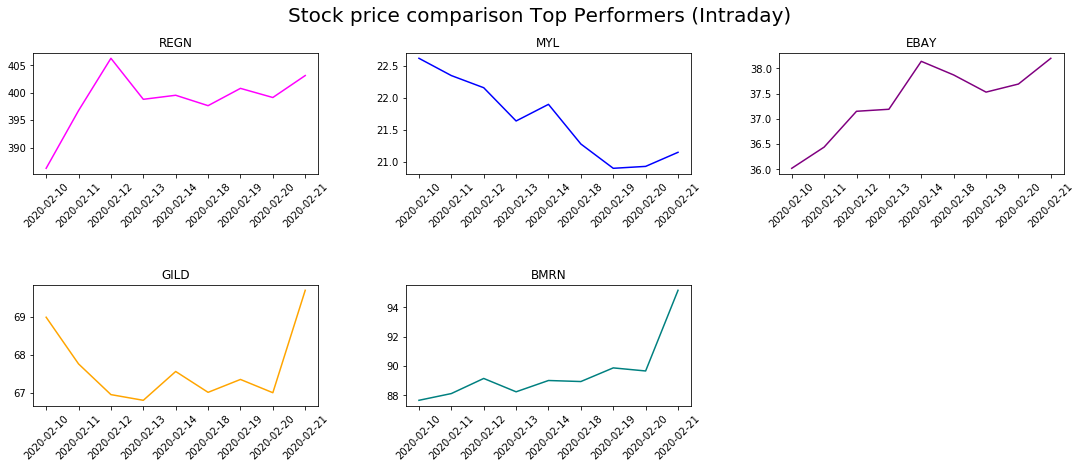

In [7]:
## Data Visualize ## Start #

# (instead of historgram since frequency of particular values not relevant)

fig = plt.figure(figsize=(16,7))
fig.suptitle('Stock price comparison Top Performers (Intraday)', fontsize=20)
colors =['magenta','blue','purple','orange','teal']

for idx in range(len(top5_list)):
  ax = fig.add_subplot(231 + idx)
  ax.set_title(top5_list[idx])
  ax.plot(df_Close.loc[top5_list[idx]], color=colors[idx])
  plt.xticks(rotation=45)
fig.tight_layout(pad=4)
plt.show()

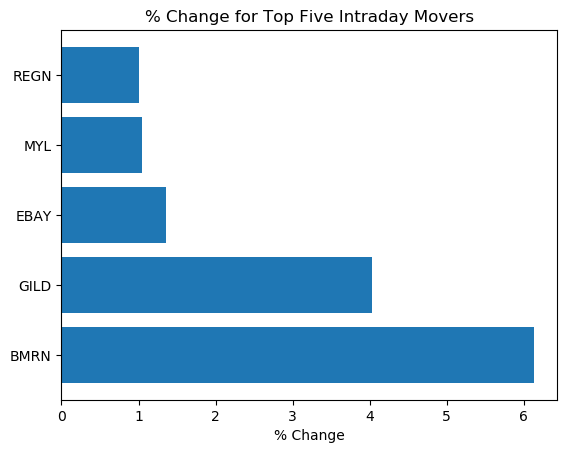

In [8]:
# top 5 movers intraday sorted by percent change

plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(top5_list))
ax.barh(y_pos, df_top5_live['change'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(top5_list)
ax.invert_yaxis()
ax.set_xlabel('% Change')
ax.set_title('% Change for Top Five Intraday Movers')
plt.show()

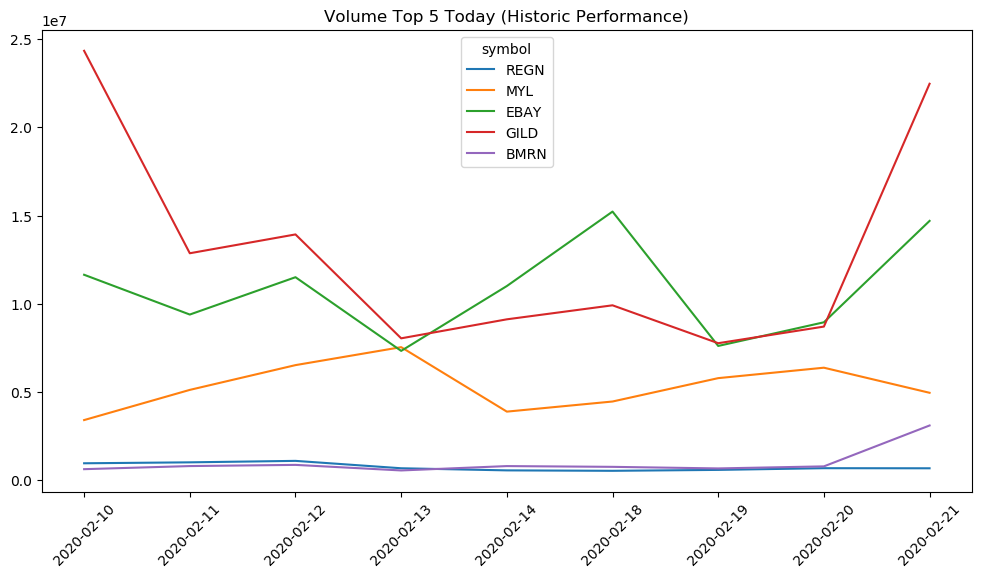

In [9]:
# top 5 movers of the day, historic volume
df_Volume.loc[df_top5_live.index].T.plot(figsize=(12,6), title='Volume Top 5 Today (Historic Performance)')
plt.xticks(rotation=45)
plt.show()

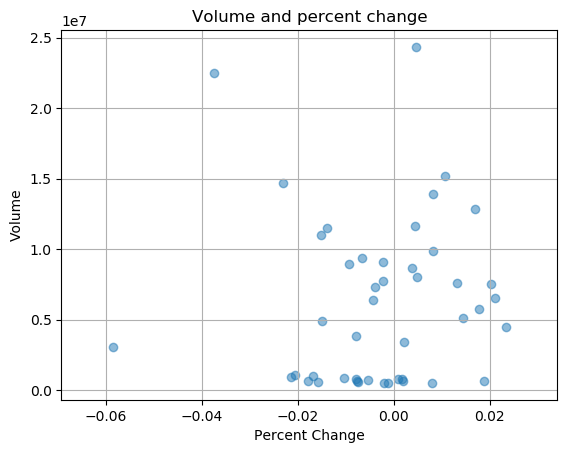

"\nfig=plt.figure() \nplt.scatter(df.Price, df.Size) \naxis = fig.gca() #get current axis \naxis.set_title('Price vs Size') \naxis.set_xlabel('Price') \naxis.set_ylabel('Size') \nfig.canvas.draw()\n"

In [10]:
# scatter plot 1
fig, ax = plt.subplots()
ax.scatter(df_pChange.loc[df_top5_live.index].T, df_Volume.loc[df_top5_live.index].T, alpha=0.5)

ax.set_xlabel('Percent Change', fontsize=10)
ax.set_ylabel('Volume', fontsize=10)
ax.set_title('Volume and percent change')
ax.grid(True)
#fig.tight_layout()
plt.show()

'''
fig=plt.figure() 
plt.scatter(df.Price, df.Size) 
axis = fig.gca() #get current axis 
axis.set_title('Price vs Size') 
axis.set_xlabel('Price') 
axis.set_ylabel('Size') 
fig.canvas.draw()
'''

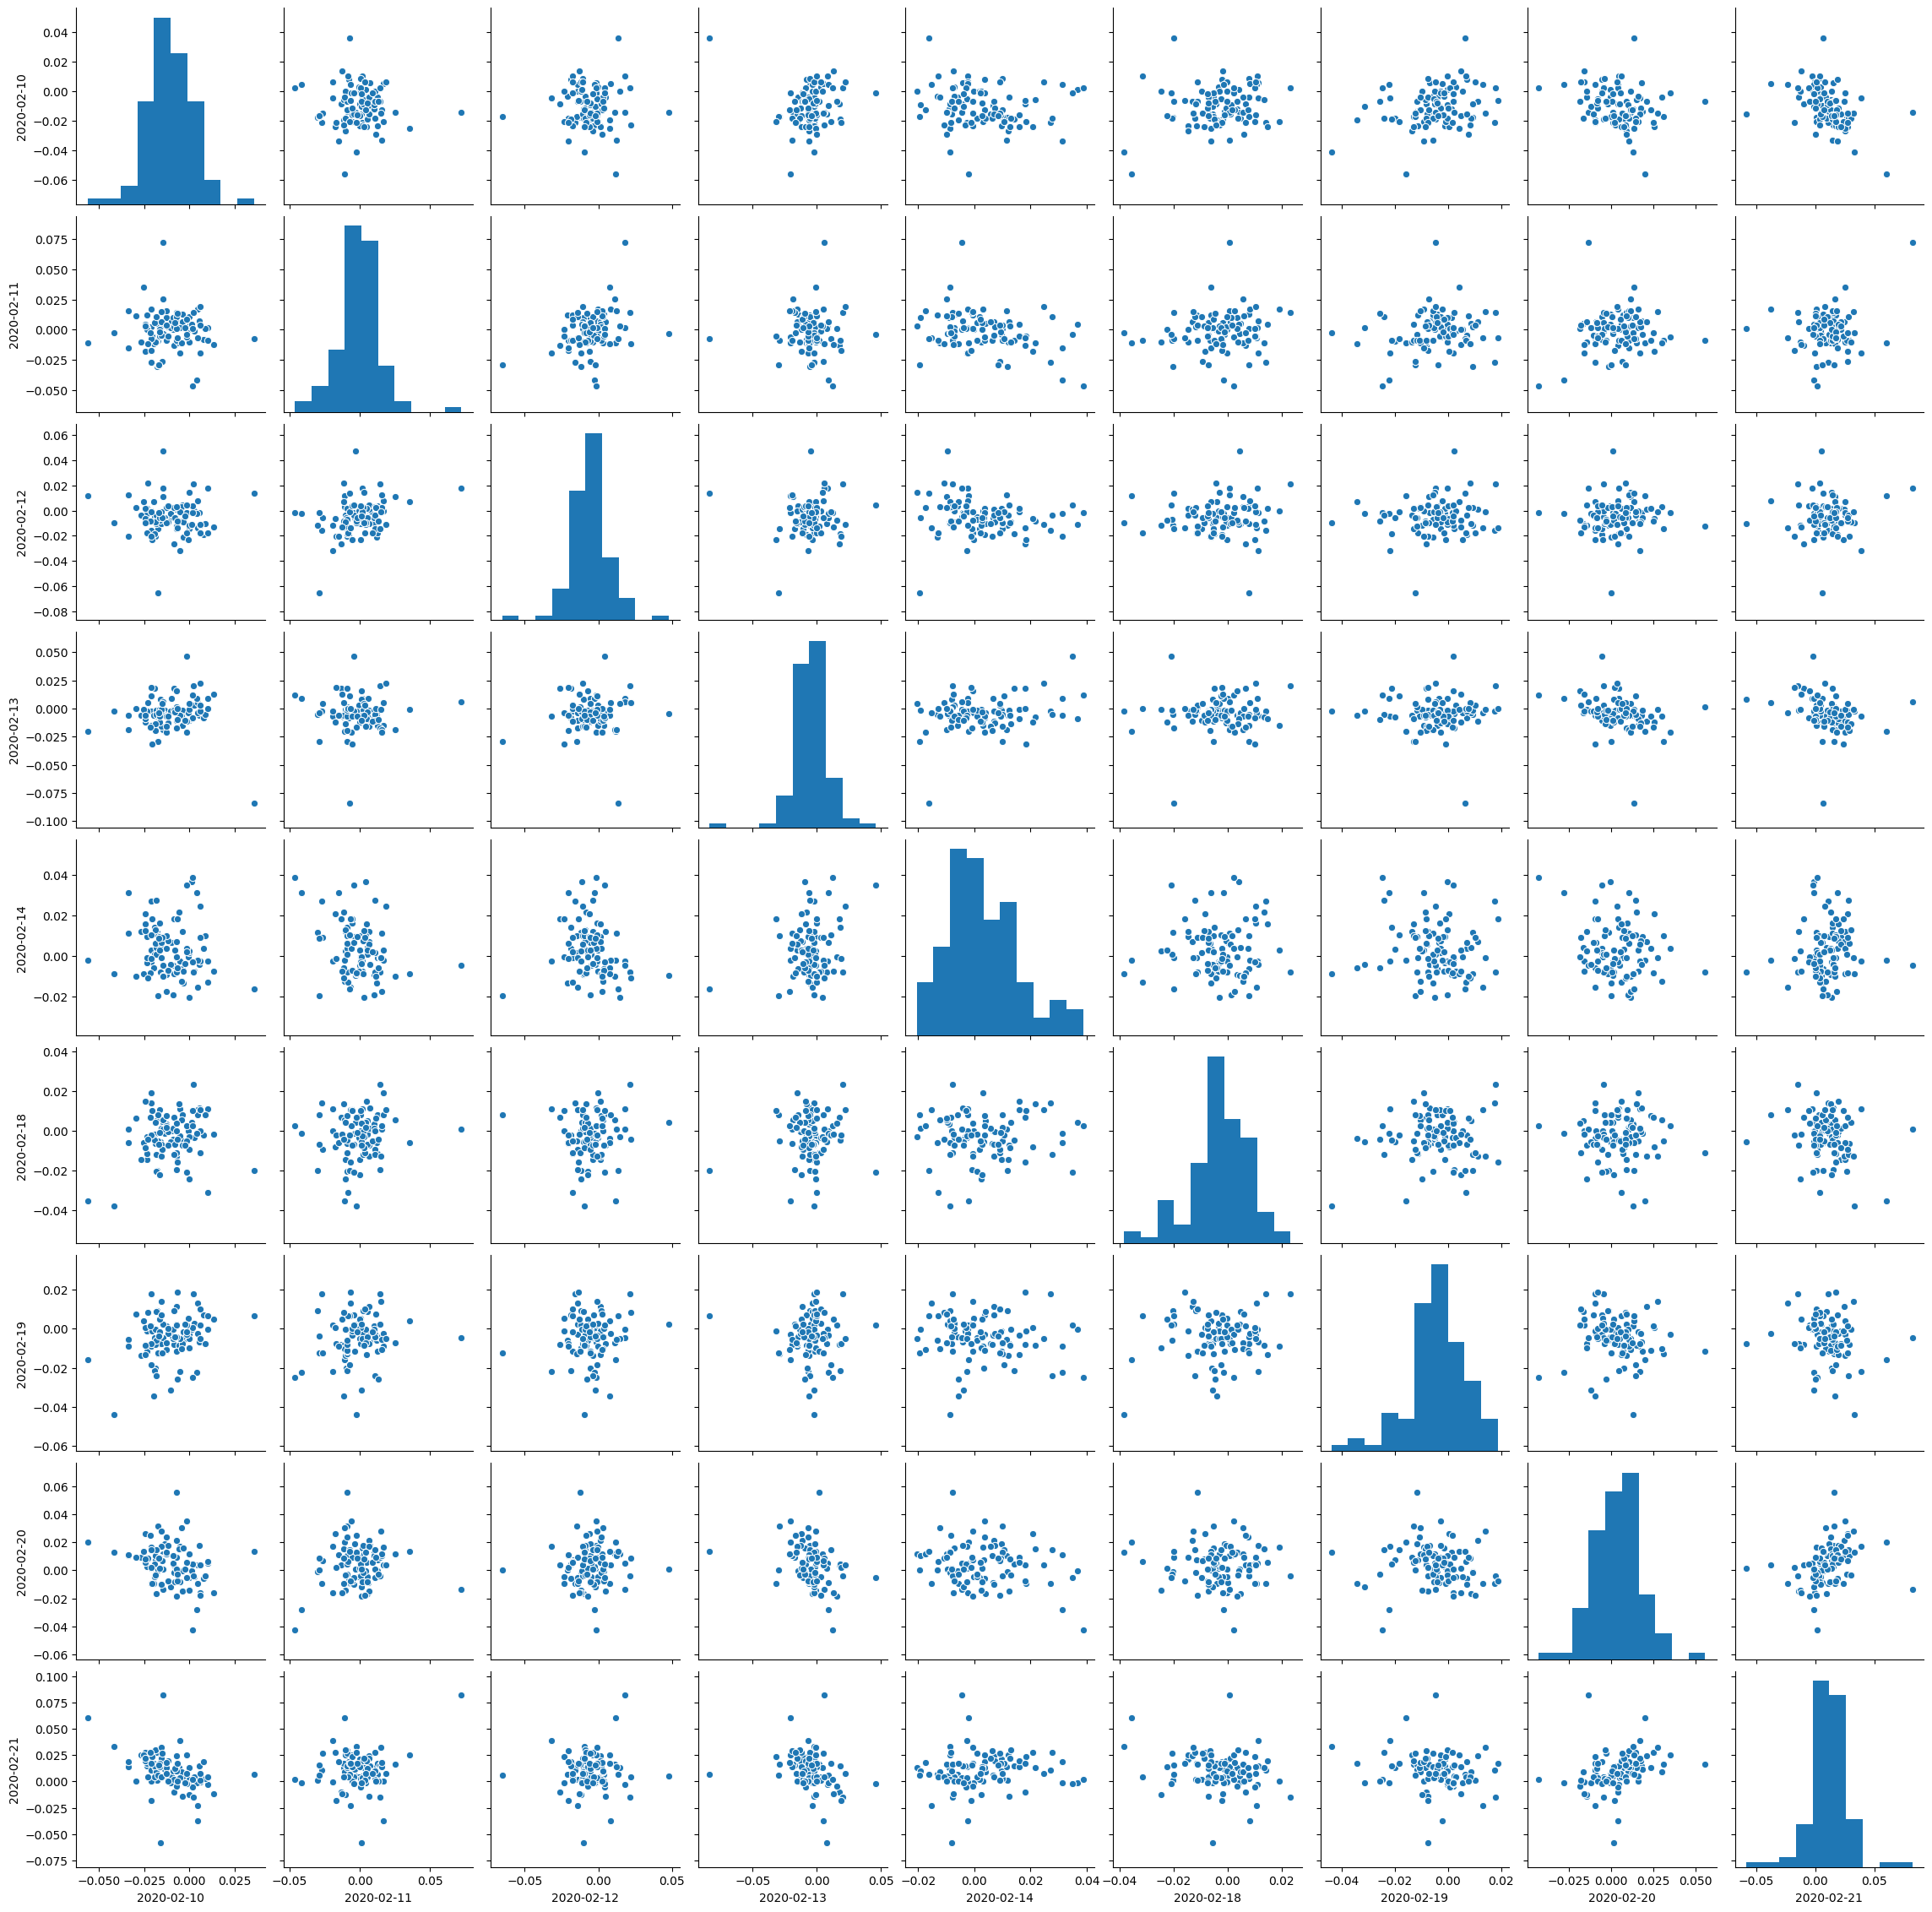

In [11]:
# scatter plot 2 (pairwise scatter plot)
sns.pairplot(df_pChange)

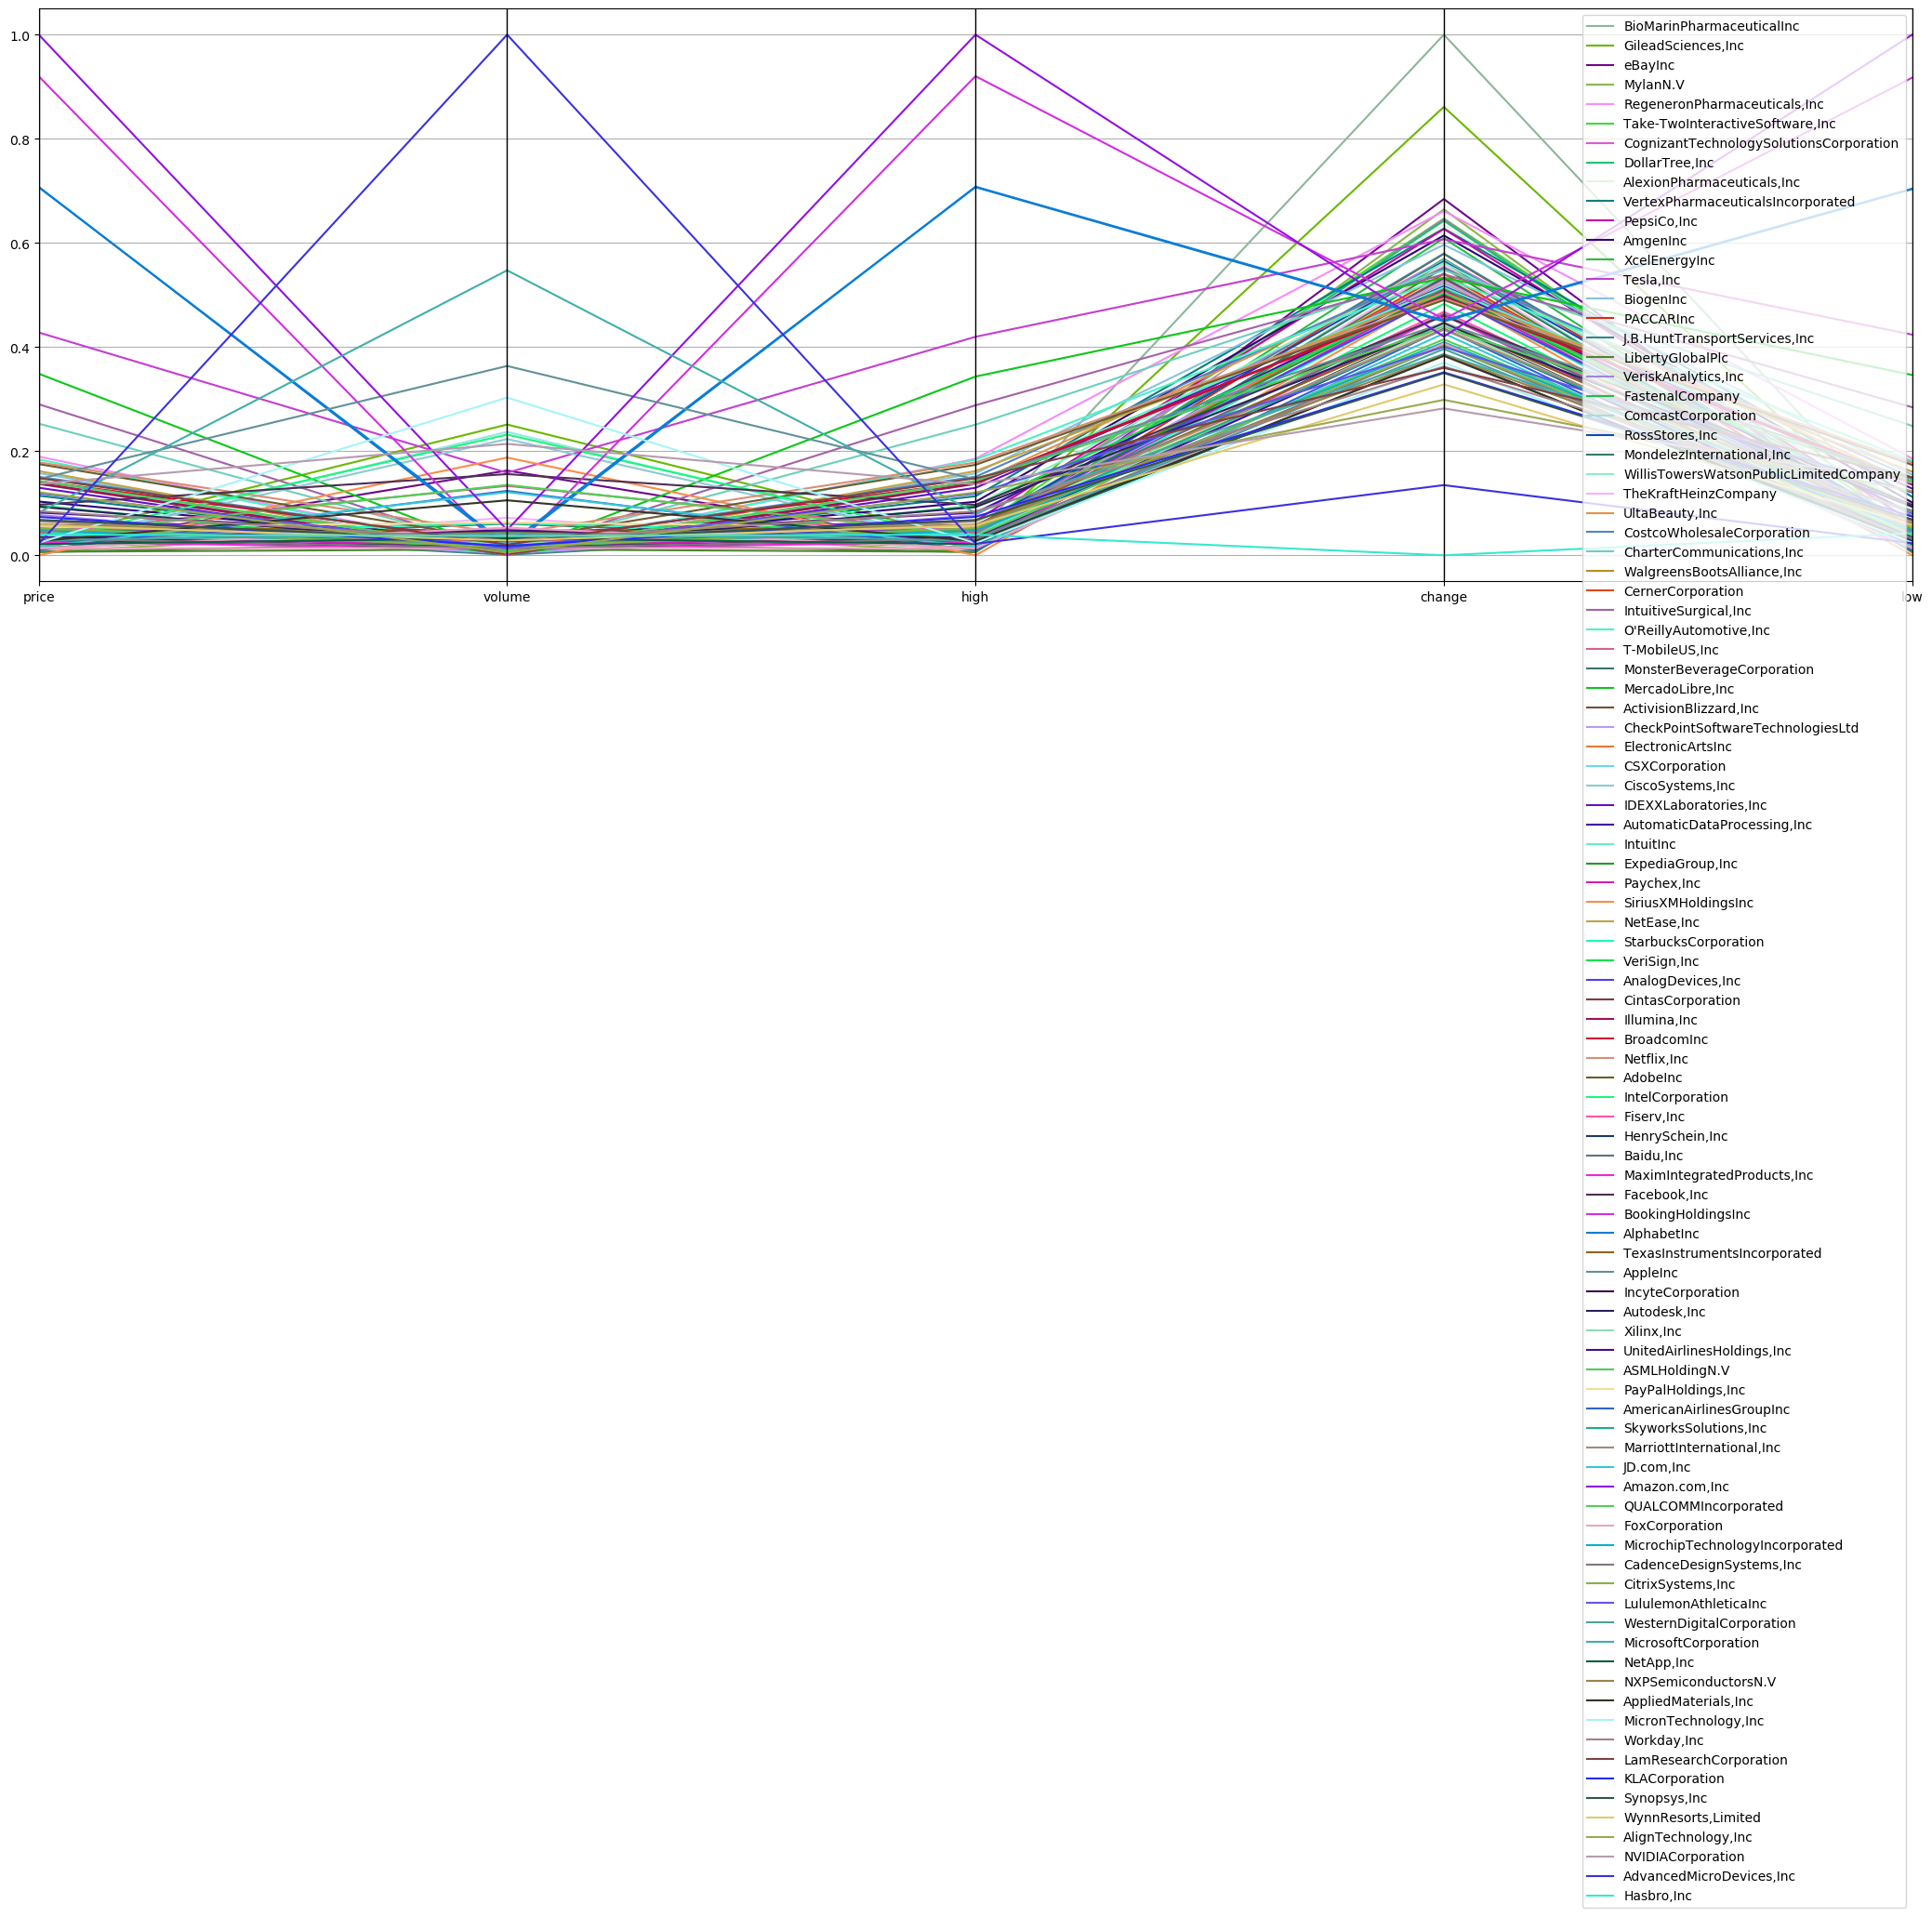

In [12]:
# parallel coordinates plot of all stocks, sorted by best movers

df = df_live.copy()

Features = ['price', 'volume', 'high', 'change', 'low']
scaler = MinMaxScaler()
df_scal = df
df_scal['name_label'] = df_live['name']
df_scal[Features] = scaler.fit_transform(df[Features])

figure(figsize=(26, 8))
df_scal = df_scal.sort_values(['change'], ascending=False)
parallel_coordinates(df_scal[['name_label','price', 'volume', 'high', 'change', 'low']], 'name_label')
fig.tight_layout()
plt.show()



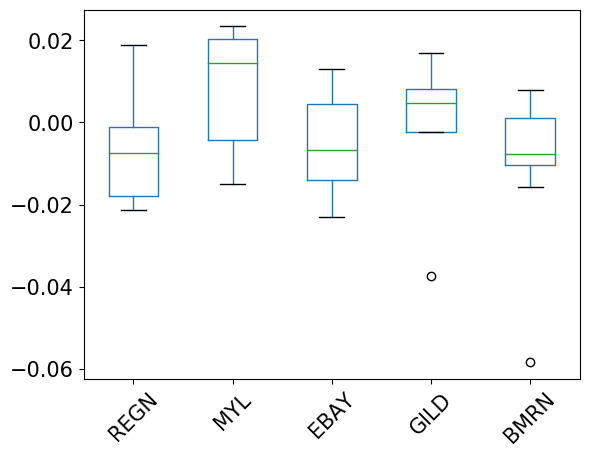

In [13]:
# boxplot pCHange of top 5 intraday

boxplot = df_pChange.loc[df_top5_live.index].T.boxplot(grid=False, rot=45, fontsize=15)

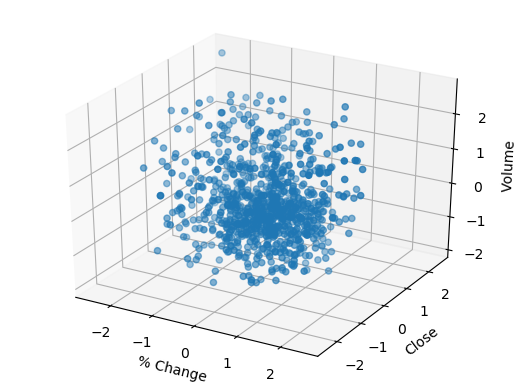

In [14]:
# 3d representation of %change, close, volume of all 100 stocks

threedee = plt.figure().gca(projection='3d')
#threedee.scatter(df_Open.loc[df_top5_live.index].T, df_Close.loc[df_top5_live.index].T, df_Volume.loc[df_top5_live.index].T)
threedee.scatter(df_pChange_normed.loc[stock_list].T, df_Close_normed.loc[stock_list].T, df_Vol_normed.loc[stock_list].T)
threedee.set_xlabel('% Change')
threedee.set_ylabel('Close')
threedee.set_zlabel('Volume')
plt.show()

## Data Visualize ## End #